In [1]:
import os
import json
import pandas as pd
import re
import warnings
from google.colab import drive
import ast
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
from itertools import chain
from collections import Counter
from operator import itemgetter
from google.colab import files
import networkx as nx

# Download NLTK resources (if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')
warnings.simplefilter(action='ignore', category=FutureWarning)
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/drive


### Create DF of Contribution Text

In [ ]:
def create_df_contribution(file_names,path):

  df_roles = pd.DataFrame(columns=['title', 'year', 'contribtuion type','address','full name'])
  df_contribution=pd.DataFrame(columns=['title', 'year', 'contribtuion type','authors','address','full name'])

  for file_name in file_names:
    print(file_name)
    path_file=path+file_name
    with open(path_file, 'r') as file:
        data = json.load(file)
    for i,key in enumerate(list(data.keys())):

      # First type of representaion of contribution types. It's a list of roles (Contribution types) for each author.
      #For exmple: roles: name_address_contribution:{full name: [Brand James, Li Xiu]
      #                                             roles:[analyze the data, wrtie the paper, performed the experients],
      #                                                   [data collection, visualization]...
      if 'name_address_contribution' in data[key]:
        lst_full_names,lst_address,lst_roles=[],[],[]
        title=data[key]['title']
        year=data[key]['year']
        try:
            for dict_names_Address in data[key]['name_address_contribution']:
              lst_full_names.append(dict_names_Address['full name'])
              lst_address.append(dict_names_Address['address'])
              lst_roles.append(dict_names_Address['roles'])
        except:
            continue

        new_row = {'title': title, 'year': year, 'contribtuion type': lst_roles,
                    'address':lst_address,'full name':lst_full_names}
        df_roles = df_roles.append(new_row, ignore_index=True)


      # Second type of representaion of contribution types. It's a string that in the string there are the roles and authors.
      #For exmple: Analyze the data: MM N.Raul PJ. Write the paper: N. Moli MN KK. ...
      if 'contribution' in data[key]:
        title=data[key]['title']
        year=data[key]['year']
        lst_full_names,lst_address=[],[]

        try:
          for dict_names_Address in data[key]['name_address']:
            lst_full_names.append(dict_names_Address['full name'])
            lst_address.append(dict_names_Address['address'])
        except:
          lst_full_names,lst_address=[],[]

        try:
          first_contrib=' '.join(data[key]['contribution'].split("\n")).split(":")

          #somethimes the first "contribution type" is a declaration. As a r result if it happened we will take the second match as
          # the first contribution.
          #For example: The author(s) have made the following declarations about their contributions: Analyze the data: KN PP ....
          if "The author(s) have made the following declarations about their contributions" in first_contrib:
            first_contrib=[first_contrib[1]]
          else:
            first_contrib=[first_contrib[0]]
        except:
          contribution_types=[]

        # I wanted to get the contibution types. They are in same stracture: ./: , space and capital letter. After that could be
        # spaces, letters (small letters) and pancuation like: -,/&.
        #As a result: (?<=\. ): Positive lookbehind assertion ensuring the match is preceded by a period and a space.
        #([A-Z][^.:]+): Captures a sequence starting with an uppercase letter, followed by one or more characters except colon and period. This covers the names of roles.
        #(?=:): Positive lookahead assertion ensuring the match is followed by a colon.
        pattern = r"(?<=\. )([A-Z][^.:]+(?=:))"
        other_contrib_types = re.findall(pattern, data[key]['contribution'])
        contribution_types=contribution_types+other_contrib_types

        #Get all the authorts that between contribution types/ from contribution type to end of the sentence.
        # From the example, I want to take: [MM N.Raul PJ. , N. Moli MN KK]
        pattern2 = '|'.join(map(re.escape, contribution_types))
        author_foreach_contrib_type = re.split(pattern2, data[key]['contribution'])

        new_row = {'title': title, 'year': year, 'contribtuion type': contribution_types,'authors':author_foreach_contrib_type,
                  'address':lst_address,'full name':lst_full_names}
        df_contribution = df_contribution.append(new_row, ignore_index=True)

  return df_contribution,df_roles

In [ ]:
path="/content/drive/MyDrive/data_mining_project/allplos/"
file_names = os.listdir(path)
df_contribution,roles_df=create_df_contribution(file_names,path)

### DF Contribution & Roles- One plus:

In [13]:
# in each cell in contribute type the value is: '['conceived','visualization'...]'.
df_contribution['contribtuion type'] = df_contribution['contribtuion type'].apply(ast.literal_eval)
df_contribution['authors']=df_contribution['authors'].apply(ast.literal_eval)
df_contribution['full name']=df_contribution['full name'].apply(ast.literal_eval)
df_contribution['address']=df_contribution['address'].apply(ast.literal_eval)

roles_df['contribtuion type'] = roles_df['contribtuion type'].apply(ast.literal_eval)
roles_df['full name'] = roles_df['full name'].apply(ast.literal_eval)
roles_df['address']=roles_df['address'].apply(ast.literal_eval)
roles_df['contribtuion type_correction']=roles_df['contribtuion type_correction'].apply(ast.literal_eval)


In [ ]:
def remove_space_from_list(lst):
    return [item for item in lst if item != '']

def remove_colon_and_dot(lst):
      return [item.replace(':', '')for item in lst]

df_contribution['authors'] = df_contribution['authors'].apply(remove_space_from_list)
df_contribution['authors'] = df_contribution['authors'].apply(remove_colon_and_dot)

In [ ]:
def Uniform_DF_Contrib_Type(lst):
  '''
  The function recieves a list of contribution of an author. The goal of this function is to create uniform names
  for a type of a contribution.
  '''
  full_contrib_types_article=[]
  for i,sub in enumerate(lst):
    full_contrib_types_author=[]
    for elem in sub:
      lst_new_contrib_Type=[]
      tokens = word_tokenize(elem)
      for token in tokens:
        if token not in '"#$%&()*+, -./:;<=>?@[\]^_`{|}~:-&':
          token=token.lower()
          lst_new_contrib_Type.append(token)
      contrib_type=' '.join(lst_new_contrib_Type)

      #there are 2 types of contribution that different each other. Writing the draft the article and
      # writing and reviewing the submitted article (not the draft)
      if 'original draft' in contrib_type:
        full_contrib_types_author.append('writing – original draft')
      elif 'review' in contrib_type:
        full_contrib_types_author.append('writing – review editing')
      #elif contrib_type in list(contrib_value_dict.keys()):
      else:
        full_contrib_types_author.append(contrib_type)

    full_contrib_types_article.append(full_contrib_types_author)
  return full_contrib_types_article

roles_df['contribtuion type_correction'] = roles_df['contribtuion type'].apply(Uniform_DF_Contrib_Type)

In [ ]:
roles_df.to_csv('roles_df_correction.csv')
df_contribution.to_csv('contribution_df.csv')

### **Roles DataFrame:**

**Count for each contribution type the amount of times authors did this taks.**

In [12]:
df_contribution=pd.read_csv("/content/drive/MyDrive/data_mining_project/contribution_df.csv")
roles_df=pd.read_csv("/content/drive/MyDrive/data_mining_project/roles_df_correction.csv")

In [ ]:
def count_foreach_contrib_type(df):
  '''
  For each article there are lists in one list in the contribution column. For each author has a list with his tasks.
  For example: [[conceptalization,visualization],[writing- review editing, formal analysis, data curtion]....]
  The function flat all the list to one list.
  The function return the amount of times each contribution type appears.
  '''
  item_counts = Counter()
  for i in range(len(df['contribtuion type_correction'])):
    flattened_list = list(chain.from_iterable(df['contribtuion type_correction'][i]))
    item_counts += Counter(flattened_list)
  return dict(item_counts)


In [ ]:
contrib_value_dict_roles=count_foreach_contrib_type(roles_df)
contrib_value_dict_roles=dict(sorted(contrib_value_dict_roles.items(),key=itemgetter(1),reverse=True))
contrib_value_dict_roles

{'writing – review editing': 604307,
 'methodology': 409980,
 'investigation': 389752,
 'conceptualization': 383881,
 'formal analysis': 327103,
 'data curation': 312270,
 'writing – original draft': 291511,
 'supervision': 250925,
 'validation': 186207,
 'project administration': 175084,
 'resources': 170362,
 'funding acquisition': 158074,
 'visualization': 143875,
 'software': 95610,
 'writing – original sdraft': 2,
 'funding-acquisition': 2,
 'visualizationa': 1,
 'conceptualizations': 1,
 'visualizationg': 1,
 'funding acquisation': 1}

flat all the lists that I will have one list that contains all the lists of contribution types (each author has a contribution types list) **After the correction**

In [ ]:
lst_all_contrib_types=[]
for contrib_type_article in roles_df['contribtuion type_correction']:
  lst_all_contrib_types+=contrib_type_article


### **DF Contribution:**

In this dataframe, there are a lot of possibilities to represent a contribution type.

As a result, I found "key words" that represent a contribution type.

In [ ]:
#the topic that we see in the roles dataframe
topics=['writing – review editing','methodology','investigation','conceptualization','formal analysis', 'data curation','writing – original draft',
                    'supervision','validation','project administration','resources','funding acquisition','visualization','software']
options_representation_contrib=[['manuscript','final version','paper','publish','literature','final approval','paper','revis','review','edit','figures','proofreading','proof reading','article','discuss','writin'],
         ['model','methodology','algorithm'],['experiment','patient','simulation','field work','fieldwork','investig'],['concept','idea','initiat','conceiv','study design'],['analyz','analys','computational','interpret','statistic','mathametic'],
         ['collect','generat','prepar','curat','extract','integr','acquir','acquis','contrib','gather','database','clean','manag','compil'], # must be data or'sampl' (sampling),
         ['draft'],['supervis'],['valid','verif','replic','reproduc'],['admin','guid','coordin','lead','technic','logist','manag'],
         ['material','reagent','tool','permission','resourc'],['financ','fundin','money','acquis'],['visual','graph'],['softwar','program','code','coding']]
contrib_options_dict = dict(zip(topics, options_representation_contrib))


In [ ]:
def flat_all_lists(df_col):
  '''
  For each article there are lists in one list in the contribution column. For each author has a list with his tasks.
  For example: [[conceptalization,visualization],[writing- review editing, formal analysis, data curtion]....]
  The function flat all the list to one list.
  '''
  lst_flat=[]
  for i in range(len(df_contribution[df_col])):
    try:
      lst_flat+=df_contribution[df_col][i]
    except:
      continue
  return lst_flat

counter_contrib_types=Counter(flat_all_lists('contribtuion type'))
#Count for each ontributuon type the amount of times it appears
counter_contrib_types=dict(sorted(counter_contrib_types.items(),key=itemgetter(1),reverse=True))

In [ ]:
counter_contrib_types

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'Analyzed the data': 166512,
 'Conceived and designed the experiments': 163955,
 'Performed the experiments': 159466,
 'Wrote the paper': 155751,
 'Contributed reagents/materials/analysis tools': 127268,
 'Conceptualization': 8413,
 'Writing – original draft': 8245,
 'Formal analysis': 8016,
 'Writing – review & editing': 8015,
 'Investigation': 7936,
 'Methodology': 7898,
 'Supervision': 7473,
 'Project administration': 6938,
 'Funding acquisition': 6863,
 'Visualization': 6676,
 'Resources': 6498,
 'Data curation': 6102,
 'Validation': 6101,
 'Contributed to the writing of the manuscript': 6031,
 'Wrote the manuscript': 6000,
 'Software': 3856,
 'ICMJE criteria for authorship read and met': 1110,
 'Wrote the first draft of the manuscript': 1030,
 'Revised the manuscript': 848,
 ' Conceived and designed the experiments': 835,
 'Agree with manuscript results and conclusions': 711,
 'Designed the software used in analysis': 639,
 'Other': 615,
 'Edited the manuscript': 514,
 'Contribut

**As we can see, there are a lot of option to write each contribution type.
As a result, I need to assign each option for his "contribution type title".
I used this site to associate each one**

https://journals.plos.org/plosbiology/s/authorship

Count for each contribution type (by specific rules) the amount of times authors did this taks type.

In [ ]:
assign_contrib_to_topic={}
for contrib in list(counter_contrib_types.keys()):
  lower_contrib=contrib.lower()
  lst_assigned=[]
  if lower_contrib in assign_contrib_to_topic:
    continue
  for options_of_represent_contrib in contrib_options_dict:

    ## By specific rules (with key words and key verbs) and with options_representation_contrib (the options that could be for each contribution type) I assign it for his
    ## contribution type title

    ## There are 4 main diffuclt tasks, so I create 4 specific conditions to them
    flag=0
    if options_of_represent_contrib=='writing – review editing':
      flag=1
      if any(substring in lower_contrib for substring in contrib_options_dict[options_of_represent_contrib]) and 'draft' not in lower_contrib:
       lst_assigned.append(options_of_represent_contrib)

    if options_of_represent_contrib=='data curation':
      flag=1
      if any(substring in lower_contrib for substring in contrib_options_dict[options_of_represent_contrib]) and lower_contrib.find('data')!=-1 and lower_contrib.find('supervis')==-1 or lower_contrib.find('sampl')!=-1 :
          if lower_contrib not in assign_contrib_to_topic:
            lst_assigned.append(options_of_represent_contrib)

    if options_of_represent_contrib=='formal analysis':
      flag=1
      if any(substring in lower_contrib for substring in contrib_options_dict[options_of_represent_contrib]) and lower_contrib.find('tool')==-1:
          if lower_contrib not in assign_contrib_to_topic:
            lst_assigned.append(options_of_represent_contrib)

    if options_of_represent_contrib=='conceptualization':
      flag=1
      if any(substring in lower_contrib for substring in contrib_options_dict[options_of_represent_contrib]) or (lower_contrib.find('design')!=-1 and lower_contrib.find('study')!=-1):
          if lower_contrib not in assign_contrib_to_topic:
            lst_assigned.append(options_of_represent_contrib)

    if any(substring in lower_contrib for substring in contrib_options_dict[options_of_represent_contrib]) and flag==0:
      lst_assigned.append(options_of_represent_contrib)

  if lower_contrib not in assign_contrib_to_topic:
        assign_contrib_to_topic[lower_contrib]=lst_assigned

In [ ]:
def Uniform_Contribution_Types(lst_contribution):
  '''
  After I assigned each task to his "contirbution type title", I need to correct them in the dataset.
  The function return dataframe with contirbution type correnction columns
  '''
  uniform_contrib_type=[]
  for contrib in lst_contribution:
    contrib_lower=contrib.lower()
    uniform_contrib_type+=assign_contrib_to_topic[contrib_lower]
  return uniform_contrib_type

df_contribution['contribtuion type_correction']= df_contribution['contribtuion type'].apply(Uniform_Contribution_Types)

In [ ]:
df_contribution.to_csv('contribution_df.csv')

In [ ]:
uniform_flat_contrib=Counter(flat_all_lists('contribtuion type_correction'))
contrib_value_dict_contribution=dict(sorted(uniform_flat_contrib.items(),key=itemgetter(1),reverse=True))

**The most popular Contribution:**

In [ ]:
summed_dict = dict(Counter(contrib_value_dict_contribution) + Counter(contrib_value_dict_roles))
summed_dict=dict(sorted(list(summed_dict.items())[:14],key=itemgetter(1),reverse=True))
summed_dict

{'writing – review editing': 818705,
 'investigation': 757653,
 'conceptualization': 589551,
 'formal analysis': 528011,
 'methodology': 420737,
 'data curation': 327642,
 'resources': 318013,
 'writing – original draft': 304631,
 'supervision': 261889,
 'validation': 193098,
 'project administration': 185734,
 'funding acquisition': 167291,
 'visualization': 151404,
 'software': 102365}

### **Connection Authors To Contribution Types:**

In [ ]:
# After the correction, there are some tasks that are very rare (They did not meet the criteria and conditions I made).
# Because they are very rare, I removed them.
df_contribution_filter = df_contribution[df_contribution['contribtuion type'].apply(lambda x: len(x)) > 1]

In [ ]:
lst_dicts_author_contributions=[]
for i,author in enumerate(df_contribution_filter['authors']):
  try:
    dict_authors_contrib_type={}
    unique_contribs=list(set(df_contribution_filter['contribtuion type_correction'][df_contribution_filter['authors'].index[i]]))
    if len(author)==len(unique_contribs):
      for j,list_authors_contrib in enumerate(author):
        pattern_acronyms1=r"[A-Z] [A-Z][a-z]+"
        pattern_acronyms2=r"(?:^| )[A-Z] [A-Z] [A-Z][a-z]+"
        pattern_Find1=re.findall(pattern_acronyms1,list_authors_contrib)
        pattern_Find2=re.findall(pattern_acronyms2,list_authors_contrib)
        if len(pattern_acronyms1)>=1:
          for pattern in pattern_Find1:
            list_authors_contrib.replace(pattern,'')
        if len(pattern_acronyms2)>=1:
          for pattern2 in pattern_Find2:
            list_authors_contrib.replace(pattern2,'')

        find_Acrononyms_of_authors=list_authors_contrib.split()+pattern_Find1+pattern_Find2
        for acuthor_Acrononym in find_Acrononyms_of_authors:
          if acuthor_Acrononym not in dict_authors_contrib_type:
            dict_authors_contrib_type[acuthor_Acrononym]=[unique_contribs[j]]
          else:
            dict_authors_contrib_type[acuthor_Acrononym]+=[unique_contribs[j]]

      lst_dicts_author_contributions.append((df_contribution_filter['authors'].index[i],dict_authors_contrib_type))

  except:
    continue

In [ ]:
lst_all_contrib_types_contribution_df=[]
for dict_author_contrib in lst_dicts_author_contributions:
  lst_all_contrib_types_contribution_df+=list(dict_author_contrib[1].values())

lst_all_Dfs=lst_all_contrib_types+lst_all_contrib_types_contribution_df

from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
te_ary = te.fit(lst_all_Dfs).transform(lst_all_Dfs)
df_contrib_encode = pd.DataFrame(te_ary, columns=te.columns_)
df_contrib_encode.head(10)

,conceptualization,conceptualizations,data curation,formal analysis,funding acquisation,funding acquisition,funding-acquisition,investigation,methodology,project administration,resources,software,supervision,validation,visualization,visualizationa,visualizationg,writing – original draft,writing – original sdraft,writing – review editing
0,False,False,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True
1,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False,False,False,False,False
5,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
6,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
7,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
8,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True
9,True,False,False,True,False,True,False,True,False,True,True,False,True,True,False,False,False,True,False,True


In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules
frequent_itemsets = apriori(df_contrib_encode, min_support=0.1, use_colnames=True)
dict_itemsets_patterns = {k: v for k, v in zip(list(frequent_itemsets['itemsets']), list(frequent_itemsets['support']))}
dict_itemsets_patterns=dict(sorted(dict_itemsets_patterns.items(),key=itemgetter(1),reverse=True))
df_patterns = pd.DataFrame(list(dict_itemsets_patterns.items()), columns=['ItemSet', 'Frequency'])
df_patterns = df_patterns[df_patterns['ItemSet'].apply(lambda x: len(x) > 1)]
df_patterns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ItemSet,Frequency
4,"(investigation, writing – review editing)",0.303997
5,"(writing – review editing, conceptualization)",0.294332
7,"(formal analysis, writing – review editing)",0.277397
8,"(formal analysis, investigation)",0.225912
9,"(investigation, conceptualization)",0.223227
11,"(formal analysis, conceptualization)",0.217034
12,"(resources, writing – review editing)",0.193362
13,"(resources, investigation)",0.192666
14,"(formal analysis, investigation, writing – rev...",0.176321
15,"(investigation, writing – review editing, conc...",0.171994


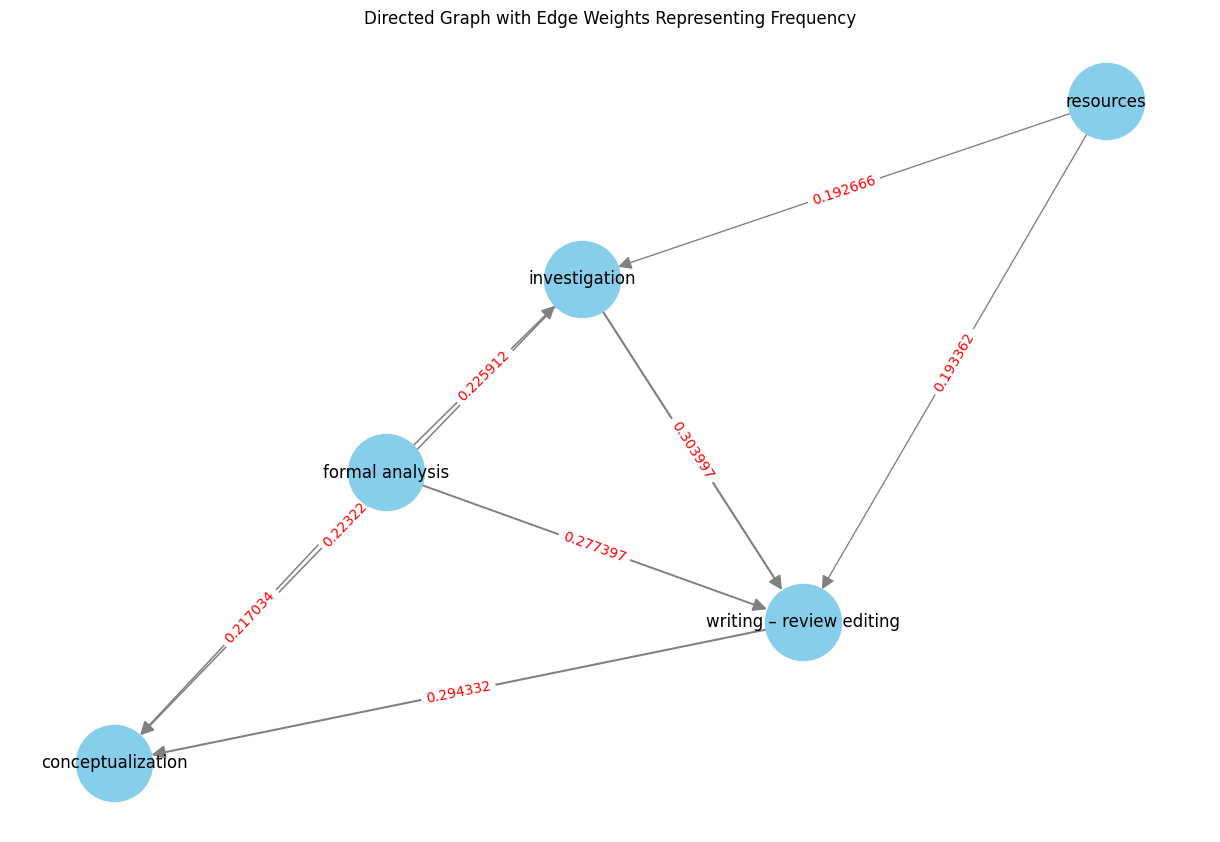

In [ ]:
df_patterns = df_patterns[df_patterns['Frequency'] > 0.19]
# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges with frequencies as edge weights
for _, row in df_patterns.iterrows():
    items = row['ItemSet']
    frequency = row['Frequency']
    G.add_edge(items[0], items[1], weight=frequency)

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
edge_widths = [5 * G.edges[u, v]['weight'] for u, v in G.edges]

nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', edge_color='gray', width=edge_widths, arrowsize=20)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='red')
plt.title('Directed Graph with Edge Weights Representing Frequency')
plt.show()


In [ ]:
nx.write_graphml(G, "graph2.graphml")


### **Word Cloud Graph To Show The most Frequenct and Rare Contribution Types**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


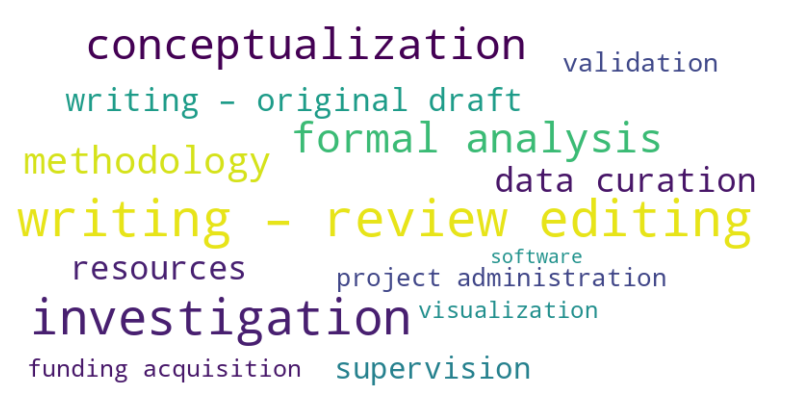

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(summed_dict)

# Plot the word cloud
plt.figure(figsize=(15, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Authors Index


In [ ]:
import itertools
def author_Acrononym_candidates(full_name,dict_acrononym_contrib,len_combination):
  '''
  There are multiple ways to write the names of the authors.
  One way is acrononym, another way their full names, other way is the caputal letter of the family name and private name (For example: F James).
  There is no uniform way to do it. one acrononym can be wrote in multiple ways. As a result we can a lot of different combinations to write the authors names.
  In addition, There are some authors that wrote their authors name in their home language. As a result I transform those letters to english letters.
  This function retreives all the combinations of an acrononym (For example: capital letter of first name and capital letters of the last name, the opposite of it.
  if there are 3 or more names it could be more difficult. For example: MNH, HMN, HNM, MHN and more...)
  '''
  translation_dict = {
        'á': 'a', 'é': 'e', 'í': 'i', 'ó': 'o', 'ú': 'u',
        'Á': 'A', 'É': 'E', 'Í': 'I', 'Ó': 'O', 'Ú': 'U',
        'ñ': 'n', 'Ñ': 'N'}
  lst_full_name=[]
  for letter in full_name:
    if letter in translation_dict.keys():
      lst_full_name.append(translation_dict[letter])
    else:
      lst_full_name.append(letter)
  combination=list(itertools.permutations(lst_full_name,len_combination))
  for comb in combination:
    candidate=''.join(comb)
    if candidate in list(dict_acrononym_contrib.keys()):
      return candidate
  return []

In [ ]:
lst_author_index_contribution_full_name=[]

for i,dict_acrononym_contrib in lst_dicts_author_contributions:
  dict_author_index_contribution_full_name={}

  for index,full_name in enumerate(df_contribution_filter['full name'][i]):
    full_name_list=re.split(r'[\s-]+', full_name)

    if len(full_name_list)==2:
      author_acrononym=full_name_list[1][0]+full_name_list[0][0]

      if author_acrononym in dict_acrononym_contrib:
        dict_author_index_contribution_full_name[author_acrononym]=[index]
      else:
        #somethimes there are same acronyms so they take the first letter of family name + private name.
        author_acrononym=full_name_list[1][0]+full_name_list[0]
        dict_author_index_contribution_full_name[author_acrononym]=[index]

    # In this types of authors could be a lot of ways to write their names.
    # For example: Michel Nathan James: MNJ, JNM, NMJ, JMN, NJM, MJN, NJ Michel, NM James. Somethimes it not in capital letters: nmj, nm james...
    # Could be '-' between the names and all the combination that I write above, could be it this type.

    elif len(full_name_list)==3 :
        try:
          first_letters = list(map(lambda word: word[0], full_name_list))
        except:
          continue
        cand=first_letters[1]+first_letters[0]
        if cand in list(dict_acrononym_contrib.keys()):
          dict_author_index_contribution_full_name[cand]=[index]
          continue
        if len(full_name_list[2])>1:
            first_letters_option=first_letters[2]+first_letters[0]
            cand=author_Acrononym_candidates(first_letters_option,dict_acrononym_contrib,len(first_letters_option))
            if cand!=[]:
              dict_author_index_contribution_full_name[cand]=[index]
              continue

        if '-' in full_name:
          capital_letters_separate=first_letters+['-']
          cand=author_Acrononym_candidates(capital_letters_separate,dict_acrononym_contrib,len(capital_letters_separate))
          if cand==[]:
            cand=author_Acrononym_candidates(first_letters,dict_acrononym_contrib,len(first_letters))
            if cand==[]:
              first_letters_option=''.join(first_letters).upper()
              cand=author_Acrononym_candidates(first_letters_option,dict_acrononym_contrib,len(first_letters_option))
              if cand==[]:
                capital_letters=re.findall(r'[A-Z]', full_name)
                cand=author_Acrononym_candidates(capital_letters,dict_acrononym_contrib,len(capital_letters))
                if cand==[]:
                  first_letters_option=first_letters[2]+first_letters[1]
                  cand=author_Acrononym_candidates(first_letters_option,dict_acrononym_contrib,len(first_letters_option))
                  if cand==[]:
                    first_letters_option=''.join(first_letters).upper()+'-'
                    cand=author_Acrononym_candidates(first_letters_option,dict_acrononym_contrib,len(first_letters_option))
                    if cand==[]:
                      first_letters_option=list(set(list(capital_letters)+list(first_letters)))
                      cand=author_Acrononym_candidates(first_letters_option,dict_acrononym_contrib,len(first_letters_option))
          try:
            dict_author_index_contribution_full_name[cand]=[index]
          except:
            continue
          continue
        else:

          cand=author_Acrononym_candidates(first_letters,dict_acrononym_contrib,len(first_letters))
          if cand==[]:
            capital_letters=re.findall(r'[A-Z]', full_name)
            cand=author_Acrononym_candidates(capital_letters,dict_acrononym_contrib,len(capital_letters))
            if cand==[]:
              first_letters_option=list(set(list(set(capital_letters))+list(set(first_letters))))
              cand=author_Acrononym_candidates(first_letters_option,dict_acrononym_contrib,len(first_letters_option))
              if cand==[]:
                first_letters_option=''.join(first_letters).upper()
                cand=author_Acrononym_candidates(first_letters_option,dict_acrononym_contrib,len(first_letters_option))
          try:
              dict_author_index_contribution_full_name[cand]=[index]
          except:
            continue

    # If there are 4 or more names (coclude the family name)
    else:
      try:
        first_letters = list(map(lambda word: word[0], full_name_list))
      except:
        continue
      cand=author_Acrononym_candidates(first_letters,dict_acrononym_contrib,len(first_letters))
      if cand==[]:
        cand=author_Acrononym_candidates(first_letters,dict_acrononym_contrib,len(first_letters)-1)
        if cand==[]:
          first_letters=''.join(first_letters).upper()
          cand=author_Acrononym_candidates(first_letters,dict_acrononym_contrib,len(first_letters)-1)

      if cand==[]:
        continue
      dict_author_index_contribution_full_name[cand]=[index]

  lst_author_index_contribution_full_name.append((i,dict_author_index_contribution_full_name))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import pickle

# Sample tuple
# Serialize the tuple to a file using pickle
file_path = "/content/author_indexes.pkl"
with open(file_path, 'wb') as file:
    pickle.dump(lst_author_index_contribution_full_name, file)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
file_path = "/content/author_contrib.pkl"
with open(file_path, 'wb') as file:
    pickle.dump(lst_dicts_author_contributions, file)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Authors Index Contribution DF:

In [2]:
import pickle
with open('/content/drive/MyDrive/data_mining_project/author_indexes.pkl', 'rb') as file:
    # Load the contents of the pickle file
    lst_author_index_contribution_full_name = pickle.load(file)

In [3]:
with open('/content/drive/MyDrive/data_mining_project/author_contrib.pkl', 'rb') as file:
    # Load the contents of the pickle file
    lst_dicts_author_contributions = pickle.load(file)

I want to add features to dataframe.
- index- The author's index position in the authors list.
- amount_authors- amount of authors in the article
- amount_of_taskks- amount of tasks an author did,
-relation amount_tasks- the realtion amount of tasks (from all the tasks in the article) an author did.
-total tasks- The amount of tasks did all the authors together in an article.

In [4]:
import numpy as np
lst_all_contributions,lst_all_indexes,lst_all_len_authors,lst_amount_taks,relation_tasks,lst_total_tasks=[],[],[],[],[],[]
df_contrib_index = pd.DataFrame()
for i, (index, dict_author_index) in enumerate(lst_dicts_author_contributions):
  dict_author_contrib_index={}
  lst_relation_amount_tasks=[]
  if lst_author_index_contribution_full_name[i][0] == index:
    if len(lst_author_index_contribution_full_name[i][1])==len(dict_author_index):
      max_index=max(list(lst_author_index_contribution_full_name[i][1].values()))
      for author_acronoym_key in lst_author_index_contribution_full_name[i][1]:
          if author_acronoym_key in dict_author_index:
            lst_all_contributions.append(dict_author_index[author_acronoym_key][:])
            lst_all_indexes.append(lst_author_index_contribution_full_name[i][1][author_acronoym_key][0])
            lst_all_len_authors.append(max_index[0])
            lst_amount_taks.append(len(dict_author_index[author_acronoym_key]))
            lst_relation_amount_tasks.append(len(dict_author_index[author_acronoym_key]))

      lst_total_tasks+=[sum(lst_relation_amount_tasks)]*len(lst_relation_amount_tasks)
      lst_relation_amount_tasks=list(np.array(lst_relation_amount_tasks)/sum(lst_relation_amount_tasks))
      relation_tasks+=lst_relation_amount_tasks

df_contrib_index['index']=lst_all_indexes
df_contrib_index['contribution']=lst_all_contributions
df_contrib_index['amount_authors']= lst_all_len_authors
df_contrib_index['amount_of_tasks']=lst_amount_taks
df_contrib_index['relation_amount_tasks']=relation_tasks
df_contrib_index['total_tasks']=lst_total_tasks


In [5]:
# I interested in 2-21 authors in an article.
df_contrib_index_filtered = df_contrib_index[df_contrib_index['amount_authors'].isin(list(range(2, 21)))]

In [6]:
df_contrib_index_filtered

,index,contribution,amount_authors,amount_of_tasks,relation_amount_tasks,total_tasks
0,0,"[resources, writing – review editing]",7,2,0.153846,13
1,1,[formal analysis],7,1,0.076923,13
2,2,[formal analysis],7,1,0.076923,13
3,3,[investigation],7,1,0.076923,13
4,4,[formal analysis],7,1,0.076923,13
...,...,...,...,...,...,...
756774,6,"[formal analysis, investigation, writing – rev...",10,3,0.073171,41
756775,7,"[resources, investigation, conceptualization, ...",10,4,0.097561,41
756776,8,"[investigation, conceptualization, writing – r...",10,3,0.073171,41
756777,9,"[investigation, conceptualization, writing – r...",10,3,0.073171,41


In [7]:
import pandas as pd

df = pd.DataFrame(df_contrib_index_filtered['contribution'])

# Convert each list of words into one-hot encoding
one_hot_encoded_df = pd.get_dummies(df['contribution'].apply(pd.Series).stack()).sum(level=0)

# Concatenate one-hot encoded DataFrame with the original DataFrame
concat_onehot_encode_tasks = pd.concat([df_contrib_index_filtered, one_hot_encoded_df], axis=1)

concat_onehot_encode_tasks

,index,contribution,amount_authors,amount_of_tasks,relation_amount_tasks,total_tasks,conceptualization,data curation,formal analysis,funding acquisition,investigation,methodology,project administration,resources,software,supervision,validation,visualization,writing – original draft,writing – review editing
0,0,"[resources, writing – review editing]",7,2,0.153846,13,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,1,[formal analysis],7,1,0.076923,13,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2,[formal analysis],7,1,0.076923,13,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,3,[investigation],7,1,0.076923,13,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,4,[formal analysis],7,1,0.076923,13,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756774,6,"[formal analysis, investigation, writing – rev...",10,3,0.073171,41,0,0,1,0,1,0,0,0,0,0,0,0,0,1
756775,7,"[resources, investigation, conceptualization, ...",10,4,0.097561,41,1,0,0,0,1,0,0,1,0,0,0,0,0,1
756776,8,"[investigation, conceptualization, writing – r...",10,3,0.073171,41,1,0,0,0,1,0,0,0,0,0,0,0,0,1
756777,9,"[investigation, conceptualization, writing – r...",10,3,0.073171,41,1,0,0,0,1,0,0,0,0,0,0,0,0,1


In [8]:
series_Group_by=df_contrib_index_filtered.groupby(['index','amount_authors'])['relation_amount_tasks'].sum().reset_index()
series_Group_by['relation_amount_tasks']=series_Group_by['relation_amount_tasks']/len(lst_dicts_author_contributions)

In [9]:
series_Group_by

,index,amount_authors,relation_amount_tasks
0,0,2,0.040082
1,0,3,0.036899
2,0,4,0.031935
3,0,5,0.025267
4,0,6,0.018931
...,...,...,...
223,18,19,0.000048
224,18,20,0.000030
225,19,19,0.000064
226,19,20,0.000038


**The connection between the position of the author in the authors list to the realtion amount of tasks**

In [10]:
series_Group_by2=df_contrib_index_filtered.groupby(['index'])['relation_amount_tasks'].sum().reset_index()
series_Group_by2['relation_amount_tasks']=series_Group_by2['relation_amount_tasks']/len(lst_dicts_author_contributions)
series_Group_by2

,index,relation_amount_tasks
0,0,0.193007
1,1,0.127713
2,2,0.109160
3,3,0.081692
4,4,0.062121
5,5,0.045746
6,6,0.032837
7,7,0.022745
8,8,0.015357
9,9,0.010133


### Authors Index Roles DF:

I want to add features to dataframe.
- index- The author's index position in the authors list.
- amount_authors- amount of authors in the article
- amount_of_taskks- amount of tasks an author did,
-relation amount_tasks- the realtion amount of tasks (from all the tasks in the article) an author did.
-total tasks- The amount of tasks did all the authors together in an article.

In [14]:
def index_foreach_contrib(roles_df_list):
  lst_indexes=[]
  for i,lst_contrib in enumerate(roles_df_list):
    lst_indexes.append(i)
  dict_index_contrib=dict(zip(lst_indexes,roles_df_list))
  return dict_index_contrib

def amount_authors_(roles_df_list):
  return [len(roles_df_list)]*len(roles_df_list)

def total_tasks(contrib_types_dict):
  lst_relation_amount_tasks,lst_total_tasks=[],[]
  for lst_contrib in list(contrib_types_dict.values()):
    lst_relation_amount_tasks.append(len(lst_contrib))
  lst_total_tasks+=[sum(lst_relation_amount_tasks)]*len(lst_relation_amount_tasks)
  return lst_total_tasks

def relation_amount_tasks(contrib_types_dict):
  lst_relation_amount_tasks,lst_total_tasks=[],[]
  for lst_contrib in list(contrib_types_dict.values()):
    lst_relation_amount_tasks.append(len(lst_contrib))

  lst_relation_amount_tasks=list(np.array(lst_relation_amount_tasks)/sum(lst_relation_amount_tasks))
  return dict(zip(list(contrib_types_dict.keys()),lst_relation_amount_tasks))

roles_df['index_contrib'] = roles_df['contribtuion type_correction'].apply(index_foreach_contrib)
roles_df['relation_contribution'] = roles_df['index_contrib'].apply(relation_amount_tasks)
roles_df['total_tasks']=roles_df['index_contrib'].apply(total_tasks)
roles_df['amount_authors'] = roles_df['full name'].apply(amount_authors_)
roles_df['Mapped_Values'] = roles_df.apply(lambda row: {key: row['amount_authors'][i] for i, key in enumerate(row['index_contrib'].keys())}, axis=1)

df_index_lenth=roles_df[['index_contrib','Mapped_Values','relation_contribution','total_tasks']]

In [15]:
df_expanded = df_index_lenth['index_contrib'].apply(pd.Series)
df_result = df_expanded.melt(value_name='Value', var_name='index')

df_expanded_length = df_index_lenth['Mapped_Values'].apply(pd.Series)
df_result_length = df_expanded_length.melt(value_name='Length', var_name='index')

df_expanded_relation = df_index_lenth['relation_contribution'].apply(pd.Series)
df_result_relation = df_expanded_relation.melt(value_name='relation_amount_tasks', var_name='index')

df_expanded_total_tasks = df_index_lenth['total_tasks'].apply(pd.Series)
df_result_total_tasks = df_expanded_total_tasks.melt(value_name='total_tasks', var_name='index')

df_result['amount_authors']=df_result_length['Length']
df_result['relation_amount_tasks']=df_result_relation['relation_amount_tasks']
df_result['total_tasks']=df_result_total_tasks['total_tasks']



In [16]:
df_result=df_result.dropna()

In [17]:
df_result=df_result[df_result['amount_authors'].isin(list(range(2, 21)))]

In [18]:
df_result

,index,Value,amount_authors,relation_amount_tasks,total_tasks
0,0,"[formal analysis, investigation, methodology, ...",10.0,0.121212,33.0
1,0,"[investigation, writing – original draft, writ...",3.0,0.250000,12.0
3,0,"[conceptualization, formal analysis, investiga...",6.0,0.233333,30.0
4,0,"[data curation, formal analysis, investigation...",11.0,0.166667,54.0
5,0,"[conceptualization, formal analysis, investiga...",11.0,0.159091,44.0
...,...,...,...,...,...
2634186,19,"[conceptualization, methodology, project admin...",20.0,0.103896,77.0
2634316,19,[writing – review editing],20.0,0.021277,47.0
2634613,19,"[conceptualization, methodology, writing – ori...",20.0,0.041667,96.0
2635113,19,"[conceptualization, data curation, funding acq...",20.0,0.118421,76.0


In [19]:
series_Group_by2_roles=df_result.groupby(['index','amount_authors'])['relation_amount_tasks'].sum().reset_index()
series_Group_by2_roles['relation_amount_tasks']=series_Group_by2_roles['relation_amount_tasks']/len(roles_df)
series_Group_by2_roles

,index,amount_authors,relation_amount_tasks
0,0,2.0,0.038319
1,0,3.0,0.047197
2,0,4.0,0.044477
3,0,5.0,0.037270
4,0,6.0,0.030849
...,...,...,...
204,17,19.0,0.000256
205,17,20.0,0.000136
206,18,19.0,0.000412
207,18,20.0,0.000180


**The connection between the position of the author in the authors list to the realtion amount of tasks**

In [20]:
series_Group_by2_roles_forindex=df_result.groupby(['index'])['relation_amount_tasks'].sum().reset_index()
series_Group_by2_roles_forindex['relation_amount_tasks']=series_Group_by2_roles_forindex['relation_amount_tasks']/len(roles_df)
series_Group_by2_roles_forindex

,index,relation_amount_tasks
0,0,0.276301
1,1,0.178552
2,2,0.130092
3,3,0.099845
4,4,0.076587
5,5,0.058587
6,6,0.042435
7,7,0.031172
8,8,0.022674
9,9,0.016286


###**2 DataFrames Together Results:**

In [21]:
lst_all_relation=series_Group_by2_roles_forindex['relation_amount_tasks']*(len(roles_df)/(len(roles_df)+len(lst_dicts_author_contributions)))+ series_Group_by2['relation_amount_tasks']*(len(lst_dicts_author_contributions)/(len(roles_df)+len(lst_dicts_author_contributions)))
df_roles_and_contribute_df=pd.DataFrame()
df_roles_and_contribute_df['index']=series_Group_by2_roles_forindex['index']+1
df_roles_and_contribute_df['relation_amount_tasks']=lst_all_relation
df_roles_and_contribute_df

,index,relation_amount_tasks
0,1,0.230647
1,2,0.150687
2,3,0.118619
3,4,0.089895
4,5,0.068658
5,6,0.051549
6,7,0.037175
7,8,0.026553
8,9,0.018664
9,10,0.012913


In [22]:
merged_df = pd.merge(series_Group_by, series_Group_by2_roles, on=['index', 'amount_authors'])
merged_df
# Calculate the new column based on values from both DataFrames
merged_df['average_relation'] = merged_df['relation_amount_tasks_x']*(len(roles_df)/(len(roles_df)+len(lst_dicts_author_contributions))) + merged_df['relation_amount_tasks_y']*(len(lst_dicts_author_contributions)/(len(roles_df)+len(lst_dicts_author_contributions)))
merged_df['index']=merged_df['index']+1
merged_df

,index,amount_authors,relation_amount_tasks_x,relation_amount_tasks_y,average_relation
0,1,2,0.040082,0.038319,0.039116
1,1,3,0.036899,0.047197,0.042543
2,1,4,0.031935,0.044477,0.038809
3,1,5,0.025267,0.037270,0.031846
4,1,6,0.018931,0.030849,0.025463
...,...,...,...,...,...
204,18,19,0.000040,0.000256,0.000159
205,18,20,0.000024,0.000136,0.000085
206,19,19,0.000048,0.000412,0.000248
207,19,20,0.000030,0.000180,0.000112


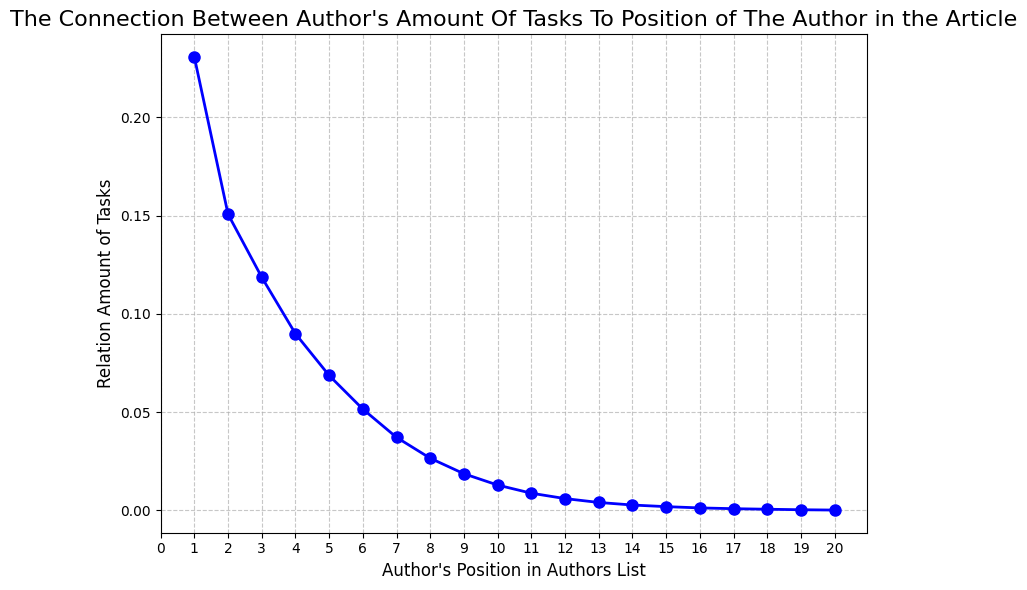

In [24]:
import matplotlib.pyplot as plt
ig, ax = plt.subplots(figsize=(8, 6))

# Plot the line graph
ax.plot(df_roles_and_contribute_df['index'], df_roles_and_contribute_df['relation_amount_tasks'], marker='o', color='blue', linewidth=2, markersize=8, label='Trendline')

# Add labels and title
ax.set_xlabel("Author's Position in Authors List", fontsize=12)
ax.set_ylabel('Relation Amount of Tasks', fontsize=12)
ax.set_title("The Connection Between Author's Amount Of Tasks To Position of The Author in the Article", fontsize=16)

# Customize ticks and grid
ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(21))
# Show plot
plt.tight_layout()
plt.show()

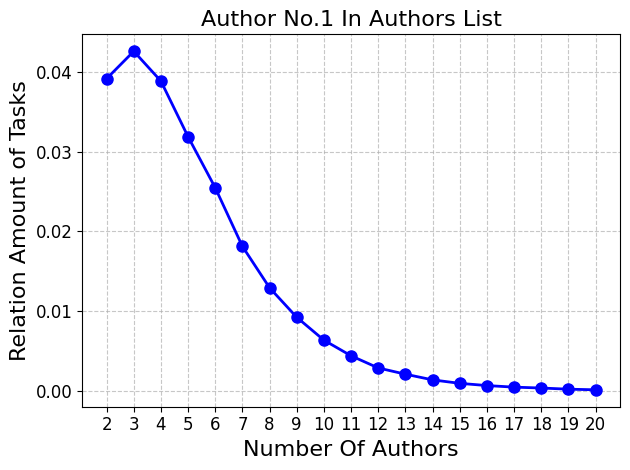

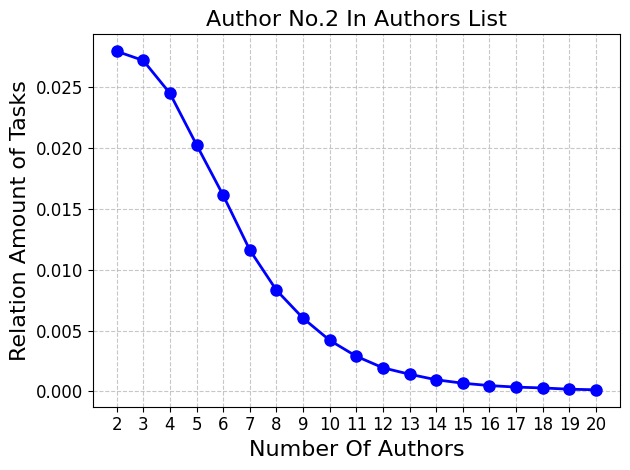

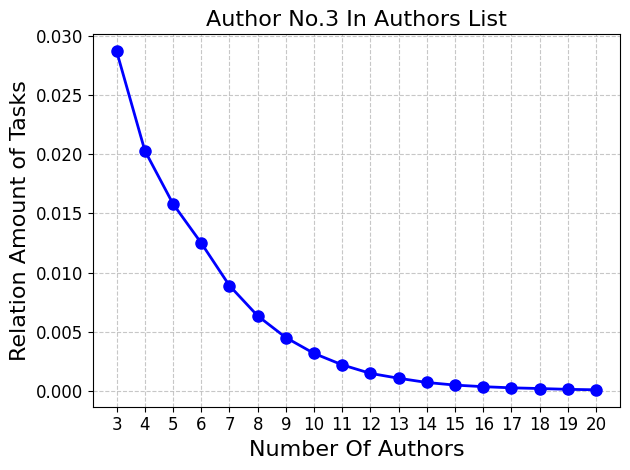

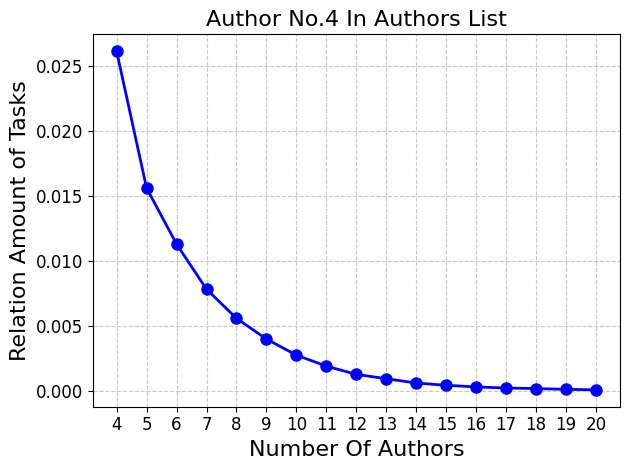

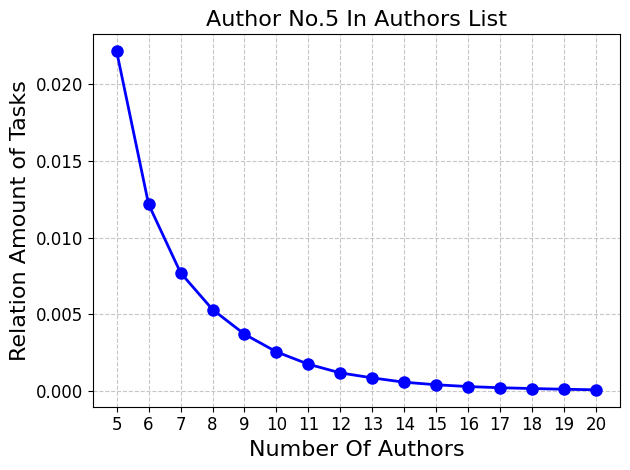

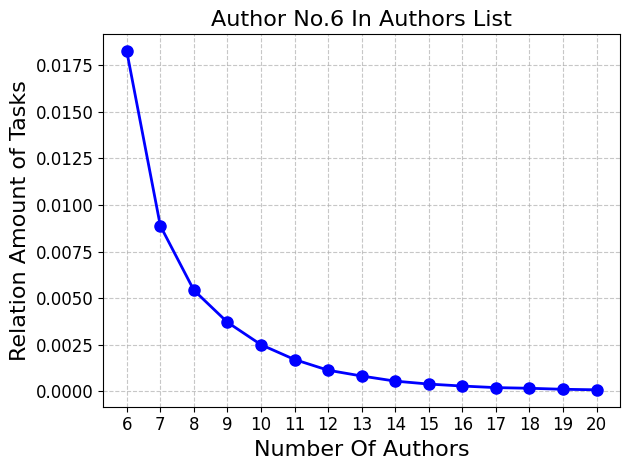

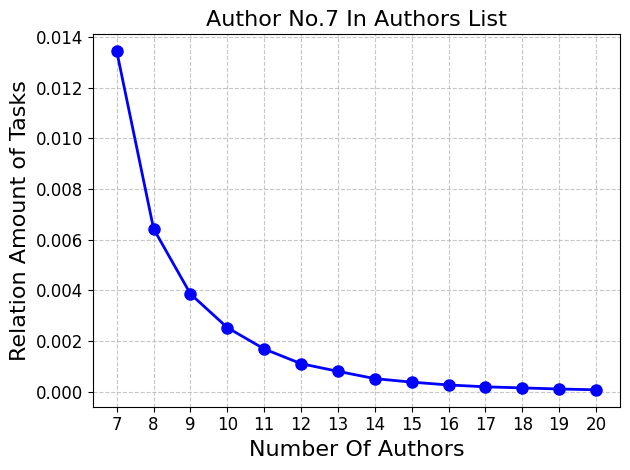

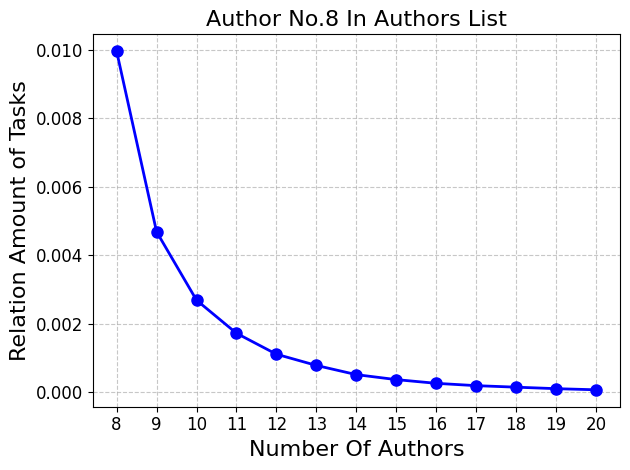

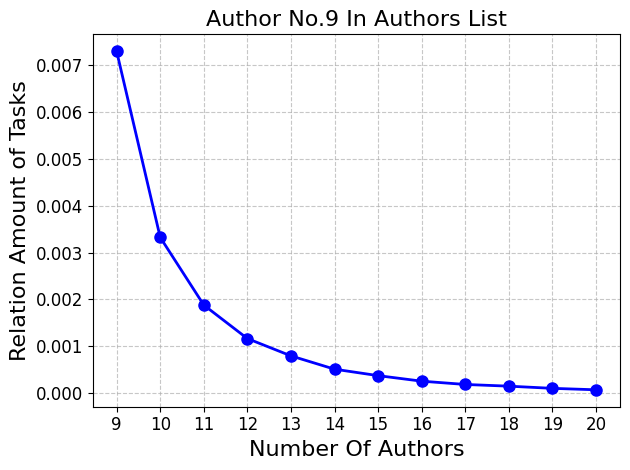

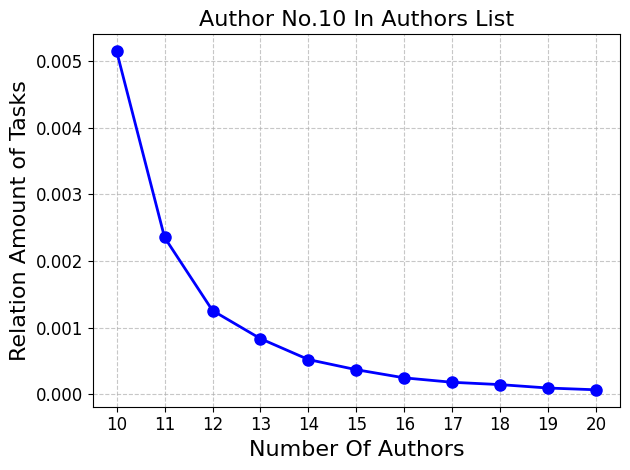

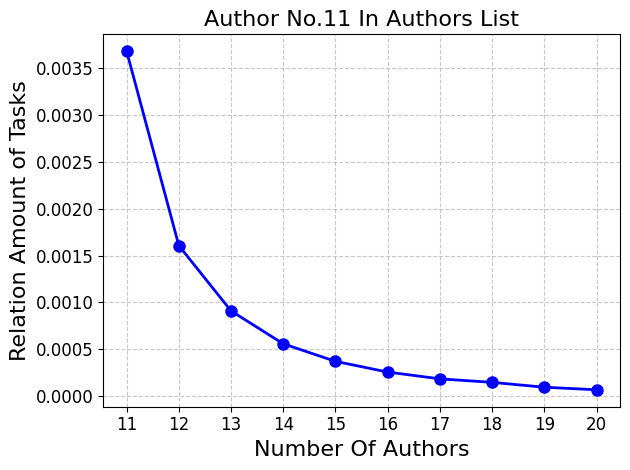

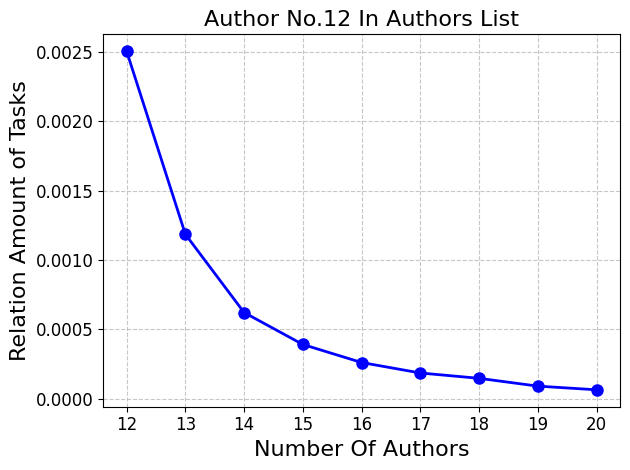

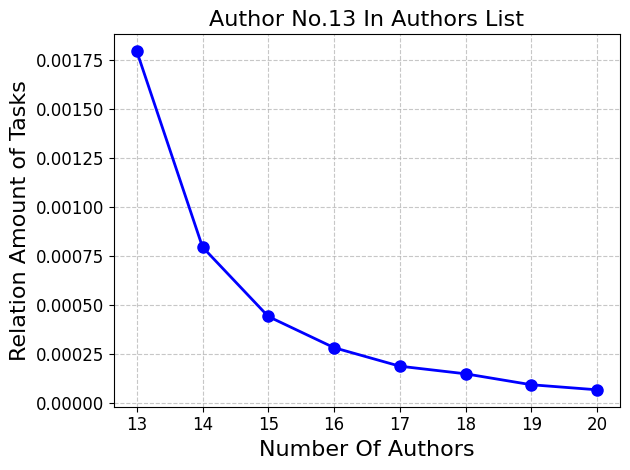

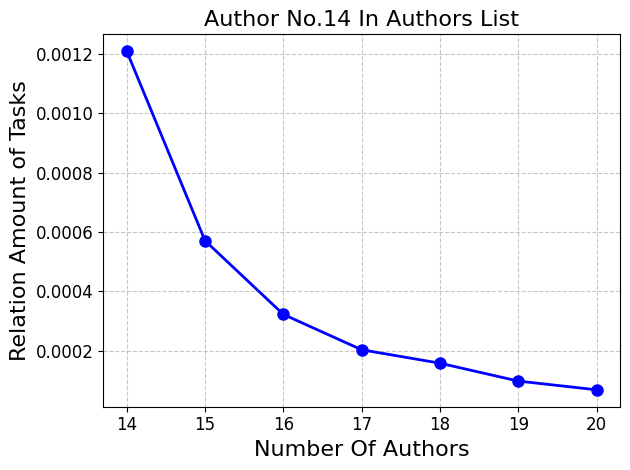

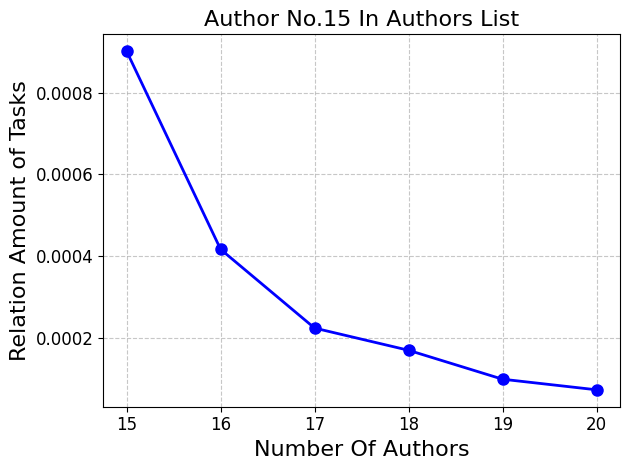

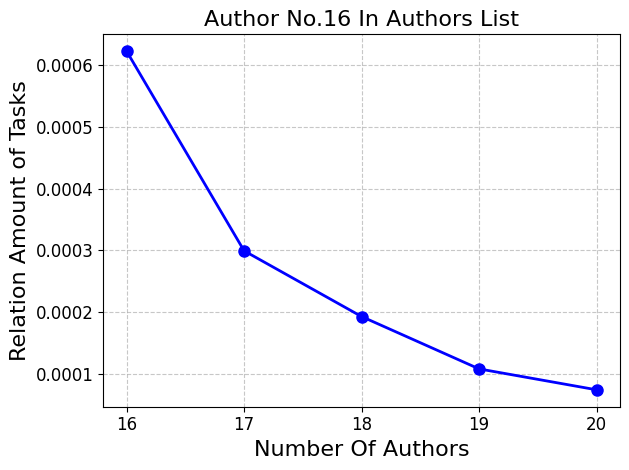

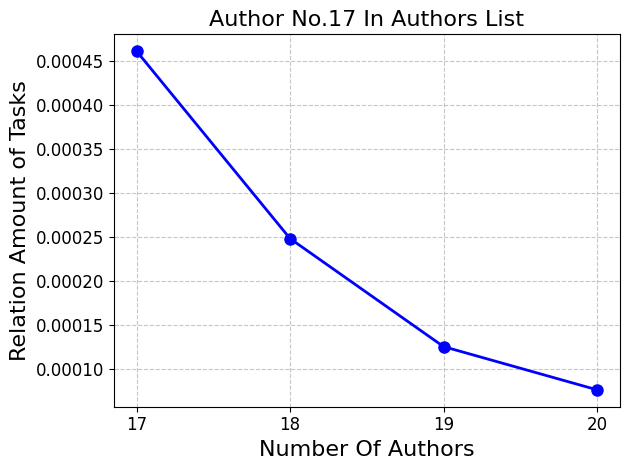

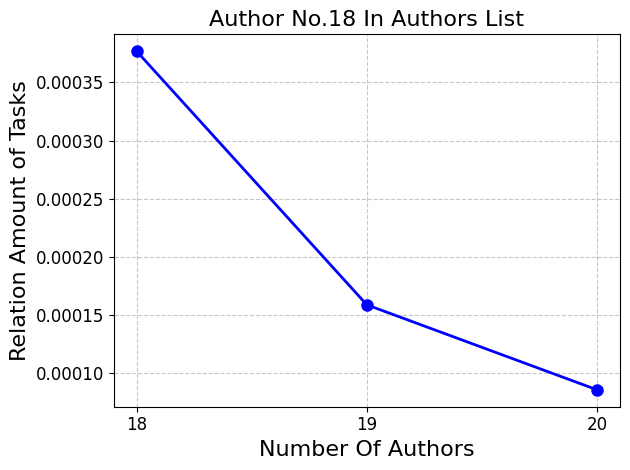

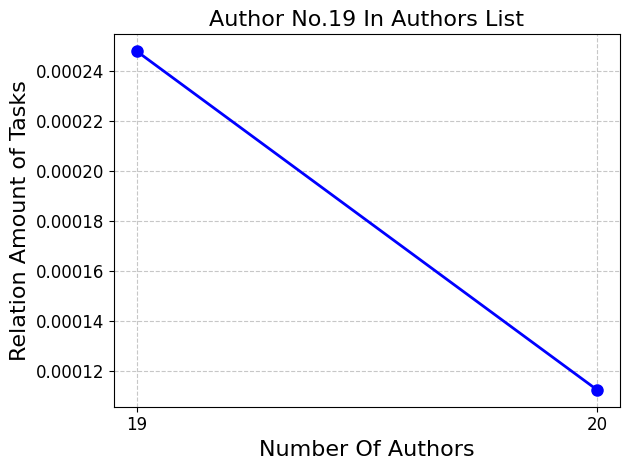

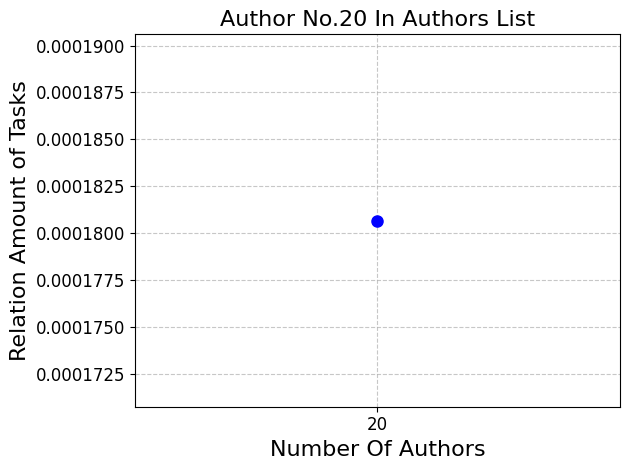

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Get unique values in the 'category' column
indexes = merged_df['index'].unique()

# Create individual plots for each unique category
for category in indexes:
    # Filter the DataFrame for the current category
    category_df = merged_df[merged_df['index'] == category]

    # Create a new figure and axis for the plot
    fig, ax = plt.subplots()

    # Plot the line for the current category
    ax.plot(category_df['amount_authors'], category_df['average_relation'], marker='o',color='blue', linewidth=2, markersize=8, label=f'Category {category}')

    # Add labels and title
    ax.set_xlabel("Number Of Authors", fontsize=16)
    ax.set_ylabel('Relation Amount of Tasks', fontsize=16)
    ax.set_title(f'Author No.{category} In Authors List', fontsize=16)

    # Customize ticks and grid
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)

    # Add legend
    plt.xticks(range(min(category_df['amount_authors']),max(category_df['amount_authors'])+1))
    # Show plot
    plt.tight_layout()
    plt.show()


### **Connection Between Contribution Type To Author's Index:**

In [ ]:
df = pd.DataFrame(df_contrib_index_filtered['contribution'])

# Convert each list of words into one-hot encoding
one_hot_encoded_df = pd.get_dummies(df['contribution'].apply(pd.Series).stack()).sum(level=0)

# Concatenate one-hot encoded DataFrame with the original DataFrame
concat_onehot_encode_tasks = pd.concat([df_contrib_index_filtered, one_hot_encoded_df], axis=1)

concat_onehot_encode_tasks

,index,contribution,amount_authors,amount_of_tasks,relation_amount_tasks,total_tasks,conceptualization,data curation,formal analysis,funding acquisition,investigation,methodology,project administration,resources,software,supervision,validation,visualization,writing – original draft,writing – review editing
0,0,"[resources, writing – review editing]",7,2,0.153846,13,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,1,[formal analysis],7,1,0.076923,13,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2,[formal analysis],7,1,0.076923,13,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,3,[investigation],7,1,0.076923,13,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,4,[formal analysis],7,1,0.076923,13,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756774,6,"[formal analysis, investigation, writing – rev...",10,3,0.073171,41,0,0,1,0,1,0,0,0,0,0,0,0,0,1
756775,7,"[resources, investigation, conceptualization, ...",10,4,0.097561,41,1,0,0,0,1,0,0,1,0,0,0,0,0,1
756776,8,"[investigation, conceptualization, writing – r...",10,3,0.073171,41,1,0,0,0,1,0,0,0,0,0,0,0,0,1
756777,9,"[investigation, conceptualization, writing – r...",10,3,0.073171,41,1,0,0,0,1,0,0,0,0,0,0,0,0,1


In [ ]:
df_roles_contrib = pd.DataFrame(df_result['Value'])

# Convert each list of contribution into one-hot encoding
one_hot_encoded_df_roles_contrib = pd.get_dummies(df_roles_contrib['Value'].apply(pd.Series).stack()).sum(level=0)

# Concatenate one-hot encoded DataFrame with the original DataFrame
concat_onehot_encode_tasks_roles_df = pd.concat([df_result, one_hot_encoded_df_roles_contrib], axis=1)

concat_onehot_encode_tasks_roles_df=concat_onehot_encode_tasks_roles_df.drop(columns=['conceptualizations','funding-acquisition','funding acquisation','visualizationa','visualizationg','writing – original sdraft'])
concat_onehot_encode_tasks_roles_df = concat_onehot_encode_tasks_roles_df.rename(columns={'Value': 'contribution'})
concat_onehot_encode_tasks_roles_df

,index,Value,amount_authors,relation_amount_tasks,total_tasks,conceptualization,data curation,formal analysis,funding acquisition,funding-acquisition,investigation,methodology,project administration,resources,software,supervision,validation,visualization,writing – original draft,writing – review editing
0,0,"[formal analysis, investigation, methodology, ...",10.0,0.121212,33.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,"[investigation, writing – original draft, writ...",3.0,0.250000,12.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0,"[conceptualization, formal analysis, investiga...",6.0,0.233333,30.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0,"[data curation, formal analysis, investigation...",11.0,0.166667,54.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
5,0,"[conceptualization, formal analysis, investiga...",11.0,0.159091,44.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2634186,19,"[conceptualization, methodology, project admin...",20.0,0.103896,77.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
2634316,19,[writing – review editing],20.0,0.021277,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2634613,19,"[conceptualization, methodology, writing – ori...",20.0,0.041667,96.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2635113,19,"[conceptualization, data curation, funding acq...",20.0,0.118421,76.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0


In [ ]:
df_combined = concat_onehot_encode_tasks_roles_df.append(concat_onehot_encode_tasks, ignore_index=True)
df_combined

,index,contribution,amount_authors,relation_amount_tasks,total_tasks,conceptualization,data curation,formal analysis,funding acquisition,investigation,methodology,project administration,resources,software,supervision,validation,visualization,writing – original draft,writing – review editing,amount_of_tasks
0,0,"[formal analysis, investigation, methodology, ...",10.0,0.121212,33.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
1,0,"[investigation, writing – original draft, writ...",3.0,0.250000,12.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN
2,0,"[conceptualization, formal analysis, investiga...",6.0,0.233333,30.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,NaN
3,0,"[data curation, formal analysis, investigation...",11.0,0.166667,54.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,NaN
4,0,"[conceptualization, formal analysis, investiga...",11.0,0.159091,44.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1582226,6,"[formal analysis, investigation, writing – rev...",10.0,0.073171,41.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
1582227,7,"[resources, investigation, conceptualization, ...",10.0,0.097561,41.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0
1582228,8,"[investigation, conceptualization, writing – r...",10.0,0.073171,41.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
1582229,9,"[investigation, conceptualization, writing – r...",10.0,0.073171,41.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0


In [ ]:
df_combined.to_csv('combination.csv')

In [2]:
df_combined=pd.read_csv('/content/drive/MyDrive/data_mining_project/combination.csv')

In [3]:
for contrib_type in list(df_combined.columns)[6:20]:
  df_combined[contrib_type]=df_combined[contrib_type]/df_combined['total_tasks']

In [4]:
df_combined

,Unnamed: 0,index,contribution,amount_authors,relation_amount_tasks,total_tasks,conceptualization,data curation,formal analysis,funding acquisition,...,methodology,project administration,resources,software,supervision,validation,visualization,writing – original draft,writing – review editing,amount_of_tasks
0,0,0,"['formal analysis', 'investigation', 'methodol...",10.0,0.121212,33.0,0.000000,0.000000,0.030303,0.0,...,0.030303,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.030303,NaN
1,1,0,"['investigation', 'writing – original draft', ...",3.0,0.250000,12.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.083333,0.083333,NaN
2,2,0,"['conceptualization', 'formal analysis', 'inve...",6.0,0.233333,30.0,0.033333,0.000000,0.033333,0.0,...,0.033333,0.000000,0.00000,0.033333,0.0,0.033333,0.000000,0.033333,0.000000,NaN
3,3,0,"['data curation', 'formal analysis', 'investig...",11.0,0.166667,54.0,0.000000,0.018519,0.018519,0.0,...,0.018519,0.018519,0.00000,0.000000,0.0,0.018519,0.018519,0.018519,0.018519,NaN
4,4,0,"['conceptualization', 'formal analysis', 'inve...",11.0,0.159091,44.0,0.022727,0.000000,0.022727,0.0,...,0.022727,0.000000,0.00000,0.000000,0.0,0.022727,0.000000,0.022727,0.022727,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1582226,1582226,6,"['formal analysis', 'investigation', 'writing ...",10.0,0.073171,41.0,0.000000,0.000000,0.024390,0.0,...,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.024390,3.0
1582227,1582227,7,"['resources', 'investigation', 'conceptualizat...",10.0,0.097561,41.0,0.024390,0.000000,0.000000,0.0,...,0.000000,0.000000,0.02439,0.000000,0.0,0.000000,0.000000,0.000000,0.024390,4.0
1582228,1582228,8,"['investigation', 'conceptualization', 'writin...",10.0,0.073171,41.0,0.024390,0.000000,0.000000,0.0,...,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.024390,3.0
1582229,1582229,9,"['investigation', 'conceptualization', 'writin...",10.0,0.073171,41.0,0.024390,0.000000,0.000000,0.0,...,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.024390,3.0


**The realtion amount of times did each tasks from all the tasks**

In [5]:
series_Group_by_indexes_tasks_combined=df_combined.groupby(['index'])[list(df_combined.columns)[6:20]].sum().reset_index()
series_Group_by_indexes_tasks2_combine=series_Group_by_indexes_tasks_combined.drop(columns=['index'])
index_sum_tasks=series_Group_by_indexes_tasks2_combine.sum(axis=1)
series_Group_by_indexes_tasks_Relation_combine = series_Group_by_indexes_tasks2_combine.div(index_sum_tasks, axis=0)
series_Group_by_indexes_tasks_Relation_combine

,conceptualization,data curation,formal analysis,funding acquisition,investigation,methodology,project administration,resources,software,supervision,validation,visualization,writing – original draft,writing – review editing
0,0.125051,0.050180,0.160978,0.016505,0.154075,0.061262,0.023756,0.080130,0.020238,0.016109,0.023711,0.029451,0.081760,0.156794
1,0.134702,0.045826,0.158024,0.020085,0.155246,0.064693,0.020976,0.075457,0.016773,0.037391,0.025008,0.018740,0.045747,0.181331
2,0.154746,0.042122,0.153361,0.021320,0.152524,0.059141,0.020430,0.081459,0.014551,0.039658,0.023958,0.015346,0.031608,0.189775
3,0.162985,0.040974,0.141827,0.024572,0.147560,0.057240,0.022542,0.088308,0.013338,0.043249,0.023377,0.014582,0.029187,0.190259
4,0.167309,0.038296,0.129528,0.028123,0.142220,0.054191,0.024854,0.098092,0.011412,0.047170,0.023412,0.014008,0.028473,0.192913
5,0.168897,0.036985,0.117622,0.030946,0.137619,0.053695,0.027418,0.105912,0.010093,0.051090,0.022802,0.013791,0.028862,0.194268
6,0.168095,0.036100,0.110107,0.032861,0.134842,0.052305,0.028747,0.113892,0.008856,0.052920,0.022681,0.013415,0.029194,0.195985
7,0.167243,0.034828,0.102630,0.035724,0.130813,0.053746,0.030508,0.117634,0.008418,0.055443,0.023077,0.014021,0.030779,0.195137
8,0.161898,0.035754,0.096434,0.038272,0.128142,0.053175,0.031962,0.121356,0.008274,0.058798,0.023254,0.014366,0.032990,0.195324
9,0.157249,0.034997,0.089664,0.041094,0.125969,0.053610,0.034588,0.124934,0.008176,0.061821,0.023887,0.015271,0.033820,0.194921


**The connection between the author's position in the authors list to a contribtion type. Will we see a more tasks in a conbtribution type to a specific index? Or more common tasks to specific indexes?**

In [6]:
transposed_df = series_Group_by_indexes_tasks_Relation_combine.melt(var_name='Column', value_name='Value')
transposed_df['index']=list(range(0,21))*len(list(df_combined.columns)[6:20])
transposed_df

,Column,Value,index
0,conceptualization,0.125051,0
1,conceptualization,0.134702,1
2,conceptualization,0.154746,2
3,conceptualization,0.162985,3
4,conceptualization,0.167309,4
...,...,...,...
289,writing – review editing,0.181261,16
290,writing – review editing,0.179070,17
291,writing – review editing,0.172393,18
292,writing – review editing,0.175276,19


In [27]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

# Define custom color map with 20 distinct colors
distinct_colors = [
    '#1f77b4',  # blue
    '#ff7f0e',  # orange
    '#2ca02c',  # green
    '#d62728',  # red
    '#9467bd',  # purple
    '#8c564b',  # brown
    '#e377c2',  # pink
    '#7f7f7f',  # gray
    'brown',  # yellow-green
    '#808080',  # cyan
    '#aec7e8',  # light blue
    '#ffbb78',  # light orange
    '#333333',  # light green
    '#ff9896']   # light red

# distinct_colors = [
#    '#1a1a1a', '#333333', '#4d4d4d', '#666666', '#808080', '#999999',
#     '#b3b3b3', '#cccccc', '#e6e6e6', '#000000', '#1a1a1a', '#333333',
#     '#4d4d4d', '#666666'
# ]
color_map=dict(zip(list(set(transposed_df['Column'])),distinct_colors))
# Assign unique numerical values to each color category
color_mapping = {color: i for i, color in enumerate(transposed_df['Column'].unique())}

# Add numerical color column to DataFrame
# Create scatter plot with Plotly
fig = px.scatter(transposed_df, x='index', y='Value', color='Column',color_discrete_map=color_map,size_max=20)

# Add range slider for filtering by color
fig.update_layout(
    title="The Connection Between Contribution Type To Author's Position In Authors List:",
    xaxis_title="Author's Position",
    yaxis_title='Relation Value',
    legend_title='Contributions Types',
    font=dict(family='Arial', size=16, color='black'),
    plot_bgcolor='white',
    paper_bgcolor='white',
    hoverlabel=dict(bgcolor='white', font_size=20),
    hovermode='closest'
)


# Show plot
fig.show()


### **Connection between First Author to contirbution (depends on the number of authors)**

In [ ]:
series_Group_by_indexes_tasks_combined=df_combined.groupby(['index'])[list(df_combined.columns)[6:20]].sum().reset_index()
series_Group_by_indexes_tasks2_combine=series_Group_by_indexes_tasks_combined.drop(columns=['index'])
index_sum_tasks=series_Group_by_indexes_tasks2_combine.sum(axis=1)
series_Group_by_indexes_tasks_Relation_combine = series_Group_by_indexes_tasks2_combine.div(index_sum_tasks, axis=0)
series_Group_by_indexes_tasks_Relation_combine

In [ ]:
groupby_index_authors=df_combined.groupby(['index','amount_authors'])[list(df_combined.columns)[6:20]].sum().reset_index()
groupby_index_authors_sum_tasks=groupby_index_authors[groupby_index_authors.columns[2:]].sum(axis=1)
groupby_index_authors_sum_tasks_relation = groupby_index_authors[groupby_index_authors.columns[2:]].div(groupby_index_authors_sum_tasks, axis=0)
groupby_index_authors_sum_tasks_relation['index']= groupby_index_authors['index']
groupby_index_authors_sum_tasks_relation['amount_authors']= groupby_index_authors['amount_authors']
groupby_index_authors_sum_tasks_relation

In [ ]:
first_Author_contribution=groupby_index_authors_sum_tasks_relation[groupby_index_authors_sum_tasks_relation['index']==0]

In [ ]:
transposed_df_first_author = first_Author_contribution[first_Author_contribution.columns[:14]].melt(var_name='Column', value_name='Value')
transposed_df_first_author['amount_authors']=list(first_Author_contribution['amount_authors'])*len(list(first_Author_contribution.columns)[:14])
transposed_df_first_author

,Column,Value,amount_authors
0,conceptualization,0.147982,2.0
1,conceptualization,0.135908,3.0
2,conceptualization,0.127883,4.0
3,conceptualization,0.120444,5.0
4,conceptualization,0.115384,6.0
...,...,...,...
261,writing – review editing,0.127411,16.0
262,writing – review editing,0.121633,17.0
263,writing – review editing,0.119847,18.0
264,writing – review editing,0.119582,19.0


In [ ]:
distinct_colors = [
    '#1f77b4',  # blue
    '#ff7f0e',  # orange
    '#2ca02c',  # green
    '#d62728',  # red
    '#9467bd',  # purple
    '#8c564b',  # brown
    '#e377c2',  # pink
    '#7f7f7f',  # gray
    'brown',  # yellow-green
    '#17becf',  # cyan
    '#aec7e8',  # light blue
    '#ffbb78',  # light orange
    '#98df8a',  # light green
    '#ff9896']   # light red

color_map=dict(zip(list(set(transposed_df_first_author['Column'])),distinct_colors))
# Assign unique numerical values to each color category
color_mapping = {color: i for i, color in enumerate(transposed_df_first_author['Column'].unique())}

# Add numerical color column to DataFrame
# Create scatter plot with Plotly
fig = px.scatter(transposed_df_first_author, x='amount_authors', y='Value', color='Column',color_discrete_map=color_map,size_max=15)

# Add range slider for filtering by color
fig.update_layout(
    title="The Connection Between Contribution Type To First Author Position In Authors List:",
    xaxis_title="Amount Of Authors",
    yaxis_title='Relation Value',
    legend_title='Contributions Types',
    font=dict(family='Arial', size=14, color='black'),
    plot_bgcolor='white',
    paper_bgcolor='white',
    hoverlabel=dict(bgcolor='white', font_size=14),
    hovermode='closest'
)


# Show plot
fig.show()

### **Connection between Last Author to contirbution (depends on the number of authors)**

In [ ]:
last_authors = groupby_index_authors_sum_tasks_relation[groupby_index_authors_sum_tasks_relation['index'] == groupby_index_authors_sum_tasks_relation['amount_authors']]
last_authors

,conceptualization,data curation,formal analysis,funding acquisition,investigation,methodology,project administration,resources,software,supervision,validation,visualization,writing – original draft,writing – review editing,index,amount_authors
38,0.235726,0.003880,0.154658,0.003478,0.151920,0.007866,0.004374,0.173337,0.003881,0.004169,0.003593,0.003955,0.004993,0.244171,2,2.0
57,0.222710,0.003463,0.142474,0.003794,0.155770,0.008317,0.004663,0.189223,0.003775,0.003861,0.004248,0.003756,0.005732,0.248213,3,3.0
75,0.207219,0.004377,0.133028,0.004072,0.160730,0.008122,0.004646,0.205238,0.003341,0.004947,0.004890,0.004403,0.005861,0.249126,4,4.0
92,0.195496,0.004952,0.123939,0.004381,0.161673,0.008127,0.005412,0.221315,0.003946,0.004733,0.004914,0.004725,0.005770,0.250616,5,5.0
108,0.183862,0.004448,0.120225,0.003828,0.163228,0.007848,0.005365,0.234661,0.002500,0.004291,0.004581,0.004542,0.005814,0.254806,6,6.0
123,0.171885,0.004903,0.117567,0.004444,0.165403,0.008884,0.005843,0.242560,0.002880,0.004735,0.005621,0.005106,0.006667,0.253500,7,7.0
137,0.165024,0.006004,0.114200,0.005187,0.165120,0.007802,0.006835,0.250072,0.002822,0.005550,0.005140,0.004870,0.006675,0.254698,8,8.0
150,0.155569,0.005066,0.106096,0.004910,0.171250,0.009179,0.006872,0.258625,0.003069,0.006449,0.005639,0.005679,0.007337,0.254260,9,9.0
162,0.148541,0.004595,0.104229,0.003923,0.174018,0.007993,0.006448,0.259220,0.003700,0.004320,0.005244,0.004211,0.006186,0.267373,10,10.0
173,0.145736,0.005990,0.102487,0.005886,0.178385,0.008743,0.006430,0.256067,0.003220,0.006234,0.005314,0.005476,0.006192,0.263841,11,11.0


In [ ]:
transposed_df_last_author = last_authors[last_authors.columns[:14]].melt(var_name='Column', value_name='Value')
transposed_df_last_author['amount_authors']=list(last_authors['amount_authors'])*len(list(last_authors.columns)[:14])
transposed_df_last_author

,Column,Value,amount_authors
0,conceptualization,0.235726,2.0
1,conceptualization,0.222710,3.0
2,conceptualization,0.207219,4.0
3,conceptualization,0.195496,5.0
4,conceptualization,0.183862,6.0
...,...,...,...
261,writing – review editing,0.246422,16.0
262,writing – review editing,0.269557,17.0
263,writing – review editing,0.257819,18.0
264,writing – review editing,0.252461,19.0


In [ ]:
distinct_colors = [
    '#1f77b4',  # blue
    '#ff7f0e',  # orange
    '#2ca02c',  # green
    '#d62728',  # red
    '#9467bd',  # purple
    '#8c564b',  # brown
    '#e377c2',  # pink
    '#7f7f7f',  # gray
    'brown',  # yellow-green
    '#17becf',  # cyan
    '#aec7e8',  # light blue
    '#ffbb78',  # light orange
    '#98df8a',  # light green
    '#ff9896']   # light red

color_map=dict(zip(list(set(transposed_df_last_author['Column'])),distinct_colors))
# Assign unique numerical values to each color category
color_mapping = {color: i for i, color in enumerate(transposed_df_last_author['Column'].unique())}

# Add numerical color column to DataFrame
# Create scatter plot with Plotly
fig = px.scatter(transposed_df_last_author, x='amount_authors', y='Value', color='Column',color_discrete_map=color_map,size_max=30)

# Add range slider for filtering by color
fig.update_layout(
    title="The Connection Between Contribution Type To Last Author Position In Authors List:",
    xaxis_title="Amount Of Authors",
    yaxis_title='Relation Value',
    legend_title='Contributions Types',
    font=dict(family='Arial', size=14, color='black'),
    plot_bgcolor='white',
    paper_bgcolor='white',
    hoverlabel=dict(bgcolor='white', font_size=14),
    hovermode='closest'
)


# Show plot
fig.show()